### Explore representational similarity, across pairs of preferred features: 
- for each session, grab trials where feat X preferred, and feat Y, compute mean neural activity
- compute cosine sim between mean activity between X and Y. TODO: compare that with computing cosine sim between all pairs, getting dist of cosine sims. depends on which gives better stats...
- compare true cosine sim dist with shuffled dist, using session permutation

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy
import itertools

from tqdm import tqdm

### Scrap, testing out code

In [4]:
def get_pseudo_frs_for_session(session, args, num_pseudo=100):
    # for grabbing behavior and firing rates, use subject-specific arguments
    # for grabbing decoder weights, use general
    sub_args = copy.deepcopy(args)
    sub_args.subject = behavioral_utils.get_sub_for_session(session)
    print(sub_args.feat)
    beh = behavioral_utils.load_behavior_from_args(session, sub_args)
    beh = behavioral_utils.get_feat_choice_label(beh, sub_args.feat)
    beh = behavioral_utils.get_belief_partitions(beh, sub_args.feat, use_x=True)

    sub_beh = beh[beh.BeliefPartition == "High X"]

    frs = spike_utils.get_frs_from_args(sub_args, session)
    frs["TimeIdx"] = (frs["Time"] * 10).round().astype(int)

    sub_frs = frs[frs.TrialNumber.isin(sub_beh.TrialNumber)]

    rng = np.random.default_rng()
    trial_nums = rng.choice(sub_frs.TrialNumber.unique(), num_pseudo)
    pseudo_trials = pd.DataFrame({"TrialNumber": trial_nums, "PseudoTrialNumber": list(range(num_pseudo))})
    pseudo_frs = pd.merge(sub_frs, pseudo_trials, on="TrialNumber")
    pseudo_frs["session"] = session
    return pseudo_frs

def get_sims(pair, args):
    (feat1, feat2) = pair.pair
    args.feat = feat1
    feat1_res = pd.concat(pd.Series(pair.sessions).apply(lambda x: get_pseudo_frs_for_session(x, args)).values)

    args.feat = feat2
    feat2_res = pd.concat(pd.Series(pair.sessions).apply(lambda x: get_pseudo_frs_for_session(x, args)).values)

    merged = pd.merge(feat1_res, feat2_res, on=["PseudoUnitID", "PseudoTrialNumber", "TimeIdx"], suffixes=["_feat1", "_feat2"], how="outer").fillna(0)

    sims = merged.groupby(["PseudoTrialNumber", "TimeIdx"]).apply(lambda x: classifier_utils.cosine_sim(x.FiringRate_feat1, x.FiringRate_feat2)).reset_index(name="cosine_sim")
    return sims

In [ ]:
BOTH_PAIRS_PATH = "/data/patrick_res/sessions/both/pairs_at_least_3blocks_10sess.pickle"
pairs = pd.read_pickle(BOTH_PAIRS_PATH).reset_index(drop=True)
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "both"
args.mode = "pref"
# args.sig_unit_level = "belief_partition_95th"
# args.sig_unit_level = "pref_99th_window_filter_drift"
args.trial_event = "StimOnset"
args.trial_interval = get_trial_interval(args.trial_event)

pair = pairs.iloc[2]
args.all_sessions = pd.DataFrame({"session_name": pair.sessions})


true_sims = get_sims(pair, args)

shuffle_sims = []
for i in tqdm(range(10)):
    args.shuffle_idx = i
    shuffle_sim = get_sims(pair, args)
    shuffle_sim["shuffle_idx"] = i
    shuffle_sims.append(shuffle_sim)
shuffle_sims = pd.concat(shuffle_sims)



    

In [6]:
pairs

,pair,sessions,num_sessions,dim_type,n_units
0,"[CIRCLE, SQUARE]","[20180615, 20180709, 20180802, 20180803, 20180...",14,within dim,415
1,"[CIRCLE, STAR]","[20180709, 20180803, 20180821, 20180911, 20180...",12,within dim,297
2,"[CIRCLE, GREEN]","[20180802, 20180806, 20180808, 20180813, 20180...",11,across dim,303
3,"[CIRCLE, MAGENTA]","[20180802, 20180803, 20180806, 20180808, 20180...",10,across dim,280
4,"[CIRCLE, YELLOW]","[20180802, 20180810, 20180813, 20180821, 20180...",14,across dim,351
5,"[CIRCLE, RIPPLE]","[20180615, 20180802, 20180803, 20180810, 20180...",10,across dim,269
6,"[SQUARE, CYAN]","[20180801, 20180802, 20180803, 20180820, 20180...",12,across dim,355
7,"[SQUARE, GREEN]","[20180802, 20180806, 20180808, 20180830, 20180...",10,across dim,273
8,"[SQUARE, MAGENTA]","[20180801, 20180802, 20180803, 20180806, 20180...",13,across dim,354
9,"[SQUARE, YELLOW]","[20180801, 20180802, 20180810, 20180820, 20180...",13,across dim,339


In [7]:
shuffle_sims.cosine_sim.mean()

0.7809537763085856

In [26]:
true_sims.cosine_sim.mean()

0.775831163311343

<Axes: xlabel='TimeIdx', ylabel='cosine_sim'>

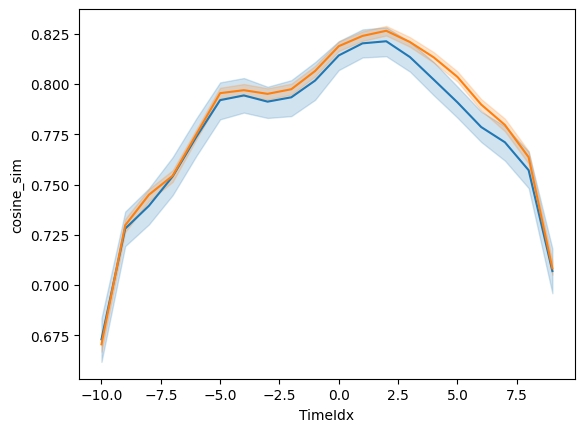

In [27]:
fig, ax = plt.subplots()
sns.lineplot(true_sims, x="TimeIdx", y="cosine_sim", ax=ax)
sns.lineplot(shuffle_sims, x="TimeIdx", y="cosine_sim", ax=ax)


### Load from runs, compare

In [10]:
def compute_within_across_diff(sim_res):
    within_res = sim_res[sim_res.dim_type == "within dim"]
    across_res = sim_res[sim_res.dim_type == "across dim"]
    merged = pd.merge(within_res, across_res, how="cross", suffixes=("_within", "_across"))
    return pd.DataFrame({"TimeIdx": sim_res.name, "diff": merged["cosine_sim_within"] - merged["cosine_sim_across"]})

def get_trial_averaged_res(args, pairs):
    all_res = []
    for i, pair in pairs.iterrows():
        args.feat_pair = pair.pair
        out_dir = belief_partitions_io.get_dir_name(args, make_dir=False)
        file_name = belief_partitions_io.get_ccgp_file_name(args)
        res = pd.read_pickle(os.path.join(out_dir, f"{file_name}_{args.sim_type}.pickle"))
        res["dim_type"] = pair.dim_type
        res["pair_str"] = "_".join(pair.pair)
        all_res.append(res)
    all_res = pd.concat(all_res)
    trial_averaged = all_res.groupby(["TimeIdx", "pair_str", "dim_type"]).cosine_sim.mean().reset_index()
    return trial_averaged

In [11]:
BOTH_PAIRS_PATH = "/data/patrick_res/sessions/both/pairs_at_least_3blocks_10sess.pickle"
pairs = pd.read_pickle(BOTH_PAIRS_PATH).reset_index(drop=True)
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "both"
args.base_output_path = "/data/patrick_res/belief_similarities"
args.sim_type = "cosine_sim"
trial_averaged = get_trial_averaged_res(args, pairs)
diffs = trial_averaged.groupby("TimeIdx").apply(compute_within_across_diff).reset_index(drop=True)

all_shuffs = []
for i in range(10):
    args.shuffle_idx = i
    shuff = get_trial_averaged_res(args, pairs)
    shuff["shuffle_idx"] = i
    all_shuffs.append(shuff)
all_shuffs = pd.concat(all_shuffs)
shuff_diffs = all_shuffs.groupby("TimeIdx").apply(compute_within_across_diff).reset_index(drop=True)

diffs["shuffle_type"] = "true"
shuff_diffs["shuffle_type"] = "shuffle"
all_diffs = pd.concat((diffs, shuff_diffs))

<Axes: xlabel='shuffle_type', ylabel='diff'>

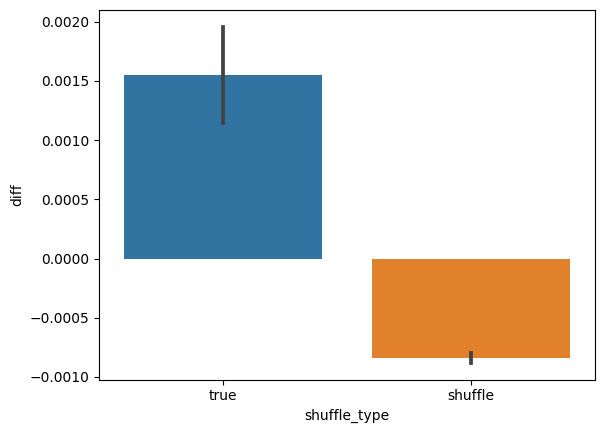

In [15]:
sns.barplot(all_diffs[all_diffs.TimeIdx <= 10], x="shuffle_type", y="diff", errorbar="se")

<Axes: xlabel='TimeIdx', ylabel='diff'>

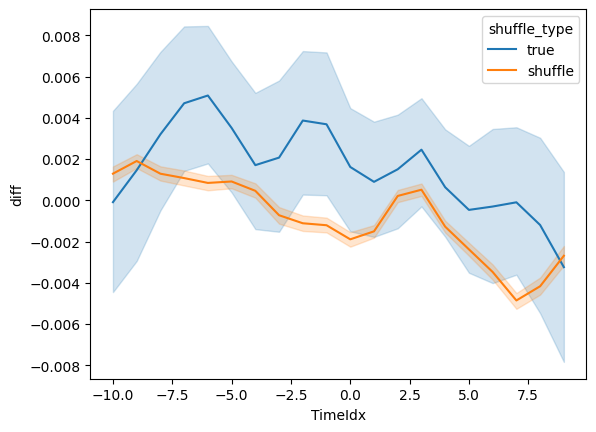

In [31]:
sns.lineplot(all_diffs, x="TimeIdx", y="diff", hue="shuffle_type")


In [29]:
from functools import reduce
import operator

def diff_per_group(group, val_col, shuffle_label_col):
    true_mean = group[group[shuffle_label_col] == "true"][val_col].mean()
    shuffle_mean = group[group[shuffle_label_col] == "shuffle"][val_col].mean()
    return true_mean - shuffle_mean

def compute_diff_in_true_shuffled(res, val_col, shuffle_label_col, groupby_cols=None):
    if groupby_cols:
        return res.groupby(groupby_cols).apply(lambda x: diff_per_group(x, val_col, shuffle_label_col)).reset_index(name="true_shuffle_diff")
    else: 
        return pd.DataFrame({"true_shuffle_diff": [diff_per_group(res, val_col, shuffle_label_col)]})


def compute_p_per_group(row, all_shuffles, groupby_cols=None):
    if groupby_cols: 
        mask = reduce(operator.and_, (all_shuffles[c] == row[c] for c in groupby_cols))
        all_shuffles = all_shuffles[mask]
    return np.mean(row.true_shuffle_diff <= all_shuffles["true_shuffle_diff"])

def compute_p_values(res, val_col, shuffle_label_col, groupby_cols=None, num_permutes=1000):
    true_diffs = compute_diff_in_true_shuffled(res, val_col, shuffle_label_col, groupby_cols)
    rng = np.random.default_rng(seed=42)
    all_shuffles = []
    for i in tqdm(range(num_permutes)):
        shuffle_data = res.copy()
        shuffle_data["shuffle_type"] = rng.permutation(res[shuffle_label_col].values)
        shuffles = compute_diff_in_true_shuffled(shuffle_data, val_col, shuffle_label_col, groupby_cols)
        shuffles["shuffle_idx"] = i
        all_shuffles.append(shuffles)
    all_shuffles = pd.concat(all_shuffles)

    return true_diffs.apply(lambda row: compute_p_per_group(row, all_shuffles, groupby_cols), axis=1)

In [26]:
all_diffs

,TimeIdx,diff,shuffle_type
0,-10,0.015338,true
1,-10,0.017505,true
2,-10,-0.020300,true
3,-10,0.007415,true
4,-10,0.001427,true
...,...,...,...
383995,9,0.012056,shuffle
383996,9,-0.012767,shuffle
383997,9,-0.037681,shuffle
383998,9,-0.031673,shuffle


In [27]:
compute_p_values(all_diffs, "diff", "shuffle_type", ["TimeIdx"])

100%|██████████| 1000/1000 [00:50<00:00, 19.65it/s]


0     0.757
1     0.609
2     0.158
3     0.030
4     0.010
5     0.058
6     0.256
7     0.075
8     0.010
9     0.005
10    0.019
11    0.056
12    0.207
13    0.108
14    0.108
15    0.136
16    0.038
17    0.008
18    0.098
19    0.598
dtype: float64

In [31]:
compute_p_values(all_diffs[all_diffs.TimeIdx < 10], "diff", "shuffle_type")

100%|██████████| 1000/1000 [00:34<00:00, 29.40it/s]


0    0.0
dtype: float64